In [1]:
import pandas as pd
import os
from typing import List, Sequence, Optional
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.formula.api import ols
import re
from backend.cuentas_nacionales.pib import PIBViews
from backend.cuentas_nacionales.pib.pib_constantes import ConstantesPIB as C
from backend.political_terms import tag_politics
from backend.plots import plot_timeseries_bars, plot_bar_subplots_by_administration, plot_stacked_bars
from backend.utils import compute_basic_statistics, calculate_component_percentages, validate_percentage_sum
from backend.contributions import compute_contributions_pipeline, summary_contributions

In [2]:
g = lambda x: x.map(lambda x:x if type(x) == str else '{:,.2f}'.format(x))

year_on_year_changes = lambda df, q: (df.pct_change(q) * 100).dropna()

In [3]:
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
# colores por presidente:

presidential_colors = {
    "Calderón":   "#9ecae1",  
    "Olsen":      "#fb6a4a",  
    "Rodríguez":  "#fdd0a2",  
    "Pacheco":    "#9467bd",  
    "Arias":      "#74c476",  
    "Chinchilla": "#fdae6b",  
    "Solís":      "#c7c7c7",  
    "Alvarado":   "#e377c2",  
    "Chaves":     "#6baed6",  
}

# <font color = 'red'> 1. DATOS

Desde el punto de vista de la Oferta, la producción nacional se desagrega en distintas actividades económicas, tales como Agricultura, Comercio, Manufactura, Salud, Construcción, entre otras. En total, actualemente el BCCR calcula 15 actividades económicas.

Estas actividades pueden agruparse para analizar la producción según los sectores económicos: Primario, Secundario y Terciario.

- El sector primario está compuesto por la actividad agrícola.

- El sector secundario corresponde a la industria, que incluye las actividades de Manufactura, Electricidad, Minas y Construcción.

- El sector terciario agrupa los servicios, que comprenden el resto de las actividades económicas.

En síntesis, desde la perspectiva de la Oferta, la producción nacional se puede analizar en dos niveles: por actividades económicas y por sectores.

Asimismo, todas estas variables pueden analizarse desde diversas perspectivas analíticas, cada una de las cuales ofrece una visión complementaria del desempeño económico:

- Crecimiento económico: mide la variación porcentual interanual de la producción, permitiendo identificar períodos de expansión o contracción en las distintas actividades y sectores. Ejemplo: en el mes $X$ del año $t$ la actividad agrícola creció 3% interanualmente.

- Composición: muestra la estructura relativa de la producción, es decir, el peso o participación que tiene cada actividad o sector dentro del total de la economía. Ejemplo: en el mes $X$ del año $t$ la actividad agrícola pesó un 5% de la producción total.

- Contribución al crecimiento económico: cuantifica el aporte específico de cada actividad o sector al crecimiento total, combinando tanto su tasa de crecimiento como su peso dentro de la producción nacional. Ejemplo: en el mes $X$ del año $t$ la ecnomomía total creció un 6%, de los cuales la actividad agrícola aportó un punto porcentual.

En conjunto, estos enfoques permiten comprender no solo cuánto crece la economía, sino también qué sectores impulsan dicho crecimiento y cómo evoluciona la estructura productiva del país.

<font color = 'skyblue'> 1.1 Datos en Millones de Colones

In [5]:
folder = r'C:\Users\adolj\OneDrive\Documentos\APPS\informed_economist\data\raw'
file_name = 'Variables_PIB_TC.xlsx'
input_path = os.path.join(folder, file_name)
dic_0 = pd.read_excel(input_path, sheet_name = None)

# datos en niveles (millones de colones)
quarterly_data_levels_TC = dic_0['pibQ'].copy()
quarterly_data_levels_TC.set_index('fecha', inplace = True)

display(g(quarterly_data_levels_TC.tail(3)))

,PIB_TC,PIB_Impuestos_TC,PIB_Valor_Agregado_TC,PIB_Agricultura_Silvicultura_Pesca_TC,PIB_Minas_Canteras_TC,PIB_Manufactura_TC,PIB_Electricidad_Agua_Saneamiento_TC,PIB_Construccion_TC,PIB_Comercio_TC,PIB_Transporte_Almacenamiento_TC,PIB_Hoteles_Restaurantes_TC,PIB_Informacion_Comunicaciones_TC,PIB_Financieras_Seguros_TC,PIB_Inmobiliario_TC,PIB_Actividades_Profesionales_TC,PIB_Administracion_Publica_TC,PIB_Ense_Salud_Asistencia_Social_TC,PIB_Otras_Actividades_TC,PIB_Demanda_Interna_TC,PIB_Gasto_Consumo_Final_TC,PIB_Gasto_Consumo_Final_Hogares_TC,PIB_Bienes_Consumo_Duradero_TC,PIB_Bienes_Consumo_Semi_Duraderos_TC,PIB_Bienes_Consumo_No_Duraderos_TC,PIB_Servicios_TC,PIB_Gasto_Consumo_Final_Gobierno_General_TC,PIB_Formacion_Bruta_Capital_Fijo_TC,PIB_Maquinaria_Equipo_TC,PIB_Nuevas_Construcciones_TC,PIB_Exportaciones_Bienes_Servicios_TC,PIB_Exportaciones_Bienes_TC,PIB_Exportaciones_Servicios_TC,PIB_Exportacion_Bienes_RegDef_TC,PIB_Exportacion_Bienes_RegEsp_TC,PIB_Importaciones_Bienes_Servicios_TC,PIB_Importaciones_Bienes_TC,PIB_Importaciones_Servicios_TC,PIB_Importacion_Bienes_RegDef_TC,PIB_Importacion_Bienes_RegEsp_TC,PIB_Combustibles_TC,PIB_Sin_Combustibles_TC,PIB_RegDef_TC,PIB_RegEsp_TC,PIB_Terminos_Intercambio,PIB_USD
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-31,"10,863,505.90","809,124.80","10,025,237.70","428,047.95","29,401.64","1,585,519.36","255,168.58","414,675.85","909,591.10","467,429.72","292,091.92","561,519.59","645,515.29","815,380.73","1,492,526.16","376,476.17","1,417,993.61","317,675.66","9,892,409.17","8,226,421.84","6,611,443.03","438,525.72","459,733.73","1,976,216.07","3,758,110.34","1,594,582.43","1,762,512.85","886,031.13","875,044.84","4,496,754.70","2,717,213.47","1,785,709.83","884,301.29","1,830,470.53","3,529,278.94","2,612,442.78","904,384.68","2,123,251.28","489,511.93","216,397.45","1,907,617.70","9,273,525.94","1,601,108.62",95.48,"25,574.57"
2025-03-31,"10,952,746.43","810,030.27","10,135,881.60","417,615.00","29,558.44","1,627,828.19","262,249.21","410,228.92","915,611.22","473,968.84","294,641.99","567,231.91","653,990.46","825,098.77","1,513,438.02","377,384.48","1,428,358.75","318,589.51","9,960,677.60","8,280,227.55","6,653,693.44","434,671.56","459,140.02","1,981,492.38","3,803,355.94","1,601,179.33","1,758,009.15","921,029.00","852,328.87","4,604,345.94","2,799,303.44","1,795,108.98","874,049.41","1,948,789.38","3,625,188.38","2,707,161.68","915,939.53","2,187,628.07","512,140.00","218,029.95","1,964,671.91","9,326,879.65","1,638,106.68",95.05,"25,445.95"
2025-06-30,"11,051,888.34","807,900.15","10,273,377.50","419,800.86","29,722.41","1,678,856.28","263,069.66","409,494.38","921,244.91","490,142.10","303,950.60","581,446.02","661,786.91","835,061.61","1,533,205.92","377,634.79","1,436,122.51","319,113.68","10,027,018.60","8,325,434.13","6,699,395.40","435,931.19","456,079.58","1,983,535.33","3,842,299.58","1,606,192.82","1,753,373.11","968,683.84","835,147.77","4,718,424.48","2,927,880.38","1,806,208.03","879,723.12","2,073,772.26","3,721,519.01","2,811,536.43","928,943.35","2,257,967.01","555,442.90","223,645.90","2,033,558.27","9,390,709.11","1,675,044.25",91.41,"24,317.12"


<font color = 'skyblue'> 1.2 Datos en Tasas de Crecimiento Interanual

In [6]:
# Las tasas de crecimiento interanual se calculan a través de la función year_on_year_changes:

yoy_df = round(year_on_year_changes(quarterly_data_levels_TC, 4), 2) # recibe datos en millones de colones y devuelve las tasas de crecimiento.

display(g(yoy_df.tail(3)))

,PIB_TC,PIB_Impuestos_TC,PIB_Valor_Agregado_TC,PIB_Agricultura_Silvicultura_Pesca_TC,PIB_Minas_Canteras_TC,PIB_Manufactura_TC,PIB_Electricidad_Agua_Saneamiento_TC,PIB_Construccion_TC,PIB_Comercio_TC,PIB_Transporte_Almacenamiento_TC,PIB_Hoteles_Restaurantes_TC,PIB_Informacion_Comunicaciones_TC,PIB_Financieras_Seguros_TC,PIB_Inmobiliario_TC,PIB_Actividades_Profesionales_TC,PIB_Administracion_Publica_TC,PIB_Ense_Salud_Asistencia_Social_TC,PIB_Otras_Actividades_TC,PIB_Demanda_Interna_TC,PIB_Gasto_Consumo_Final_TC,PIB_Gasto_Consumo_Final_Hogares_TC,PIB_Bienes_Consumo_Duradero_TC,PIB_Bienes_Consumo_Semi_Duraderos_TC,PIB_Bienes_Consumo_No_Duraderos_TC,PIB_Servicios_TC,PIB_Gasto_Consumo_Final_Gobierno_General_TC,PIB_Formacion_Bruta_Capital_Fijo_TC,PIB_Maquinaria_Equipo_TC,PIB_Nuevas_Construcciones_TC,PIB_Exportaciones_Bienes_Servicios_TC,PIB_Exportaciones_Bienes_TC,PIB_Exportaciones_Servicios_TC,PIB_Exportacion_Bienes_RegDef_TC,PIB_Exportacion_Bienes_RegEsp_TC,PIB_Importaciones_Bienes_Servicios_TC,PIB_Importaciones_Bienes_TC,PIB_Importaciones_Servicios_TC,PIB_Importacion_Bienes_RegDef_TC,PIB_Importacion_Bienes_RegEsp_TC,PIB_Combustibles_TC,PIB_Sin_Combustibles_TC,PIB_RegDef_TC,PIB_RegEsp_TC,PIB_Terminos_Intercambio,PIB_USD
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-31,4.29,3.87,4.08,-0.10,0.58,6.58,-1.54,3.60,2.73,7.48,0.23,5.25,5.95,4.37,6.19,1.40,2.10,2.10,3.70,3.03,3.16,5.15,10.61,2.65,2.57,1.52,7.22,7.89,4.77,6.08,9.46,1.53,3.96,11.70,4.97,3.86,7.27,4.92,0.42,-9.80,7.27,3.51,9.60,1.06,9.20
2025-03-31,4.07,2.54,4.17,-3.89,0.96,8.01,2.23,2.46,2.64,7.39,0.07,4.05,5.79,4.26,5.95,1.38,2.47,2.33,3.35,3.09,2.87,3.13,6.74,2.38,3.37,1.79,5.87,8.55,1.90,7.27,10.76,1.11,0.92,17.11,5.33,4.17,6.84,4.40,4.63,-10.84,7.05,3.19,10.05,1.32,7.07
2025-06-30,3.94,1.07,4.56,-3.39,1.87,10.25,2.59,0.31,2.53,7.85,3.43,4.78,5.08,4.34,5.67,1.09,2.61,1.85,3.02,2.76,2.81,0.57,2.28,1.58,3.92,1.69,0.92,10.03,-2.61,8.39,14.37,1.29,0.99,23.31,6.37,8.03,6.57,6.67,14.13,-6.26,9.25,3.04,10.32,0.20,5.61


In [7]:
# O bien, con la clase PIBViews se puede acceder a las diferentes desagregaciones del PIB y luego se calculan las tasas de crecimiento.

# Por ejemplo:

ob_pibv = PIBViews(quarterly_data_levels_TC) # a esta clase se le ingresa los datos en millones de colones
industrias_millones = ob_pibv.oferta.get_categorias_principales() # luego se accede a los datos que se necesiten
industrias_tasas_crecimiento = year_on_year_changes(industrias_millones, q = 4)
display(g(industrias_tasas_crecimiento.tail(3)))


,PIB_TC,PIB_Valor_Agregado_TC,PIB_Impuestos_TC
fecha,,,
2024-12-31,4.29,4.08,3.87
2025-03-31,4.07,4.17,2.54
2025-06-30,3.94,4.56,1.07


<font color = 'skyblue'> 1.3 Datos Composición

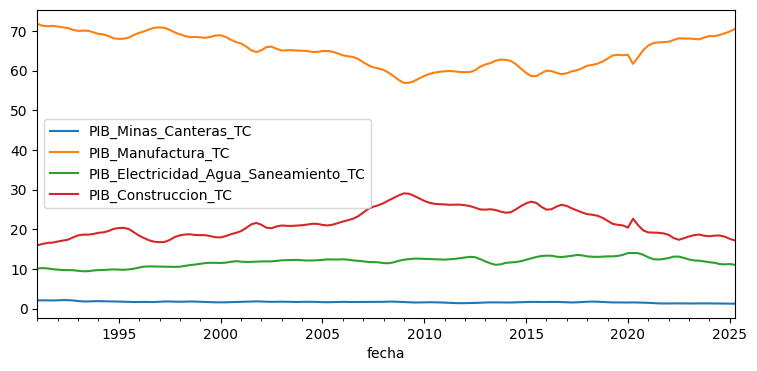

In [8]:
# Los pesos relativos se calculan con la función calculate_component_percentages, la cual
# recibe una dataframe con variables en millones de colones: un variable debe totalizar las demás.

# Ej:

# Le pasaré al objeto PIBViews los datos en millones de colones para poder acceder a desagregaciones y poder calcular
# los pesos relativos:

ob_pibv = PIBViews(quarterly_data_levels_TC)

# Como mencioné, el Sector Secundario se compone de las Industrias: Manufactura, Electricidad, Minas y Canteras.
# ¿Cuánto pesa cada una ellas dentro del total de dicho sector?:

# a la función calculate_component_percentages se le debe pasar un dataframe e indicarle cuál de las columnas es la total:
df_percentages = calculate_component_percentages(
    df = ob_pibv.oferta.get_industria_ampliada(), # accedo a las variables del Sector Secundario.
    total_col = 'Industria_Ampliada_TC')

df_percentages.plot(figsize=(9, 4))
plt.show()

# Se observa que la actividad económica con más peso dentro del Sector Secundario es la Manufactura:

# (ignorar el gráfico tan horrible):

In [9]:
validate_percentage_sum(df_percentages)

✅ Percentage check: 138/138 rows within ±0.05 of 100.0.


{'n_total': 138,
 'n_valid': np.int64(138),
 'n_invalid': np.int64(0),
 'invalid_rows': [],
 'max_abs_deviation': 0.01}

<font color = 'skyblue'> 1.4 Datos Contribuciones

In [10]:
# Las contribuciones se calculan a través de la función compute_contributions_pipeline.

# Esta función requiere que se le pasen dos dataframes:
#   1) Las tasas de crecimiento interanuales (que ya vimos que se calcula con year_on_year_changes)
#   2) Los pesos relativos (que ya vimos que se calcula con calculate_component_percentages)


✅ Suma de contribuciones por fila  ≈ crecimiento total:


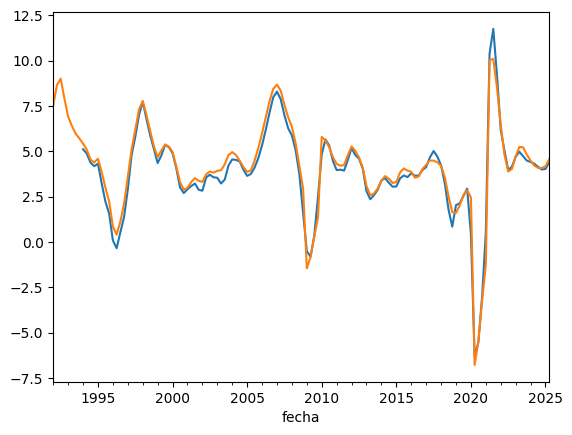

In [11]:
# Ejemplo:

# Voy a calcular la contribución que cada atividad económica tuvo en el crecimiento total.

# 1) Cálculo de pesos relativos: ¿cuánto pesa cada actividad económica del total?
df_total_e_industrias = pd.concat([ob_pibv.oferta.get_valor_agregado(), ob_pibv.oferta.get_industrias()], axis = 1).loc[:]
df_weights = calculate_component_percentages(df = df_total_e_industrias, total_col = 'PIB_Valor_Agregado_TC')

# 2) Tasas de crecimiento interanuales:
# Estas las podemos acceder a través del objeto PIBViews: 
industrias_millones = ob_pibv.oferta.get_industrias()
df_growth = year_on_year_changes(industrias_millones, q = 4)

# ------> 

contrib_pp, weights_validation, tidy_panel = compute_contributions_pipeline(df_growth=df_growth, df_weights=df_weights, return_long  = True)

print("\n✅ Suma de contribuciones por fila  ≈ crecimiento total:")
contrib_pp.sum(axis=1).squeeze().plot()
yoy_df['PIB_Valor_Agregado_TC'].plot()
plt.show()

# (ignorar el gráfico tan horrible):

<font color = 'skyblue'> 1.5 Administraciones

In [12]:
# FInalmente, la función tag_politics permite asignarle a cada mes-año un label la administración correspondiente:

tagged_df = tag_politics(quarterly_data_levels_TC)
display(g(tagged_df[['PIB_TC','Label']]))

,PIB_TC,Label
fecha,,
1991-03-31,"2,635,510.73",Calderón
1991-06-30,"2,673,943.81",Calderón
1991-09-30,"2,720,920.54",Calderón
1991-12-31,"2,784,461.84",Calderón
1992-03-31,"2,852,136.48",Calderón
...,...,...
2024-06-30,"10,632,541.70",Chaves
2024-09-30,"10,742,947.00",Chaves
2024-12-31,"10,863,505.90",Chaves


In [13]:
tagged_df.groupby('Label').count()['President']

Label
Alvarado      16
Arias         16
Calderón      13
Chaves        13
Chinchilla    16
Olsen         16
Pacheco       16
Rodríguez     16
Solís         16
Name: President, dtype: int64

# <font color = 'red'> 2. RESULTADOS

In [14]:
# Ejemplos de visualizaciones.

## <font color = 'red'> 2.1 TASAS DE CRECIMIENTO INTERANUALES

Se mide el ritmo de crecimiento de la producción de bienes y servicios. 

Para cada variable $Y_t$ se calcula su tasa de crecimiento interanual: $\Delta \% = \frac{Y_t}{Y_{t-12}} - 1$ 

### <font color = 'red'> 2.1.1 ECONOMÍA NACIONAL

In [15]:
# Notar el flujo:
#   con el objeto PIBViews se accede a la información requerida. Luego se le calculan los cambios de crecimiento interanuales:

df = year_on_year_changes(ob_pibv.oferta.get_categorias_principales(), q = 4)
df.columns = df.columns.str.replace('_TC', '')
df.info()
print('\n')
col = 'PIB'
statistic = 'mean'

pib = df[[col]]
pib = tag_politics(pib)
pib = pib[pib['Label'] != 'Calderón']

stats_by_admin = compute_basic_statistics(pib, value_col=col, groupby_col='Label')
stats_by_admin = stats_by_admin.sort_values(by = statistic, ascending = False).round(2)

fig_pib_label = plot_timeseries_bars(
    df=pib,
    start = '1994-06-30',
    y_col=col,
    category_col="Label",
    title=f"Costa Rica: Crecimiento Interanual del {col} por Administración",
    x_title="",
    y_title="(%)",
    y_round=2,
    y_suffix="",
    width=850,
    height=420,
    zero_line=False,
    showlegend=True,
    colors=presidential_colors,
    template='plotly_white',
    show_y_grid=True
)

fig_pib_label.show()

display(stats_by_admin[[statistic]].transpose())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1992-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PIB                 134 non-null    float64
 1   PIB_Valor_Agregado  134 non-null    float64
 2   PIB_Impuestos       134 non-null    float64
dtypes: float64(3)
memory usage: 4.2 KB




Label,Arias,Chaves,Rodríguez,Pacheco,Chinchilla,Olsen,Solís,Alvarado
mean,4.8,4.48,4.34,4.25,4.18,4.12,3.88,2.36


### <font color = 'red'> 2.1.2 PIB POR ACTIVIDAD ECONÓMICA

In [16]:
df = year_on_year_changes(ob_pibv.oferta.get_industrias(), q = 4)
df.columns = df.columns.str.replace('_TC', '')
df.info()
print('\n')
col = 'PIB_Construccion'
statistic = 'mean'

pib = df[[col]]
pib = tag_politics(pib)
pib = pib[pib['Label'] != 'Calderón']

stats_by_admin = compute_basic_statistics(pib, value_col=col, groupby_col='Label')
stats_by_admin = stats_by_admin.sort_values(by = statistic, ascending = False).round(2)

fig_pib_label = plot_timeseries_bars(
    df=pib,
    start = '1994-06-30',
    y_col=col,
    category_col="Label",
    title=f"Costa Rica: Crecimiento Interanual {col} por Administración",
    x_title="",
    y_title="(%)",
    y_round=2,
    y_suffix="",
    width=850,
    height=420,
    zero_line=False,
    showlegend=True,
    colors=presidential_colors,
    template='plotly_white',
    show_y_grid=True
)

fig_pib_label.show()

display(stats_by_admin[[statistic]].transpose())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1992-03-31 to 2025-06-30
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PIB_Agricultura_Silvicultura_Pesca  134 non-null    float64
 1   PIB_Minas_Canteras                  134 non-null    float64
 2   PIB_Manufactura                     134 non-null    float64
 3   PIB_Electricidad_Agua_Saneamiento   134 non-null    float64
 4   PIB_Construccion                    134 non-null    float64
 5   PIB_Comercio                        134 non-null    float64
 6   PIB_Transporte_Almacenamiento       134 non-null    float64
 7   PIB_Hoteles_Restaurantes            134 non-null    float64
 8   PIB_Informacion_Comunicaciones      134 non-null    float64
 9   PIB_Financieras_Seguros             134 non-null    float64
 10  PIB_Inmobiliario                    134 non-null    float64
 11  PIB_Actividades_Profesiona

Label,Arias,Rodríguez,Pacheco,Chaves,Olsen,Solís,Chinchilla,Alvarado
mean,9.75,8.74,3.95,3.36,2.52,2.15,-2.0,-2.47


### <font color = 'red'> 2.1.3 POR SECTORES (PRIMARIO, SECUNDARIO, TERCIARIO)

In [17]:
df = ob_pibv.oferta.get_sectores()
df.columns = df.columns.str.replace('_TC', '')
df.rename(columns={'Industria_Ampliada': 'Industria'}, inplace = True)
df = year_on_year_changes(df, q = 4)
df = tag_politics(df).drop(['President', 'Party', 'Term'], axis = 1)


components = ['Agro', 'Servicios', 'Industria']
means = df.groupby("Label")[components].mean()
to_remove = ["Calderón", "Pacheco", "Rodríguez", "Olsen"]
means = means.drop(index=to_remove, errors="ignore")
fig = plot_bar_subplots_by_administration(df = means, variables = components, colors = presidential_colors, title = "PIB: Promedio por Administración de los Componentes de la Demanda", y_title = "Crecimiento Interanual (%)")
fig.show()

g(means.loc[['Chaves', 'Alvarado', 'Solís', 'Chinchilla', 'Arias']])

,Agro,Servicios,Industria
Label,,,
Chaves,0.93,4.48,5.14
Alvarado,0.20,1.90,4.00
Solís,2.19,4.58,2.11
Chinchilla,2.74,5.20,1.21
Arias,1.77,6.04,2.35


### <font color = 'red'> 2. COMPOSICIÓN

In [18]:
# luego lo hago

### <font color = 'red'> 3. CONTRIBUCIONES

In [19]:
# luego lo hago